<a href="https://colab.research.google.com/github/Esbern/Sankey-diagrams/blob/main/genneral%20sankey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note before using Plotly in Jupiter lab it is necessary not only to install the Pyton libary but also the Jupiter lab extension
for instance micromamba install -c conda-forge jupyterlab-plotly-extension

In [1]:
import requests
import json
import pandas as pd
import plotly.graph_objects as go

In [2]:
class Table:
    """
    Represents a database table and handles fetching of data from Airtable,
    storing it in a pandas DataFrame. It manages label and relationship
    lists with lazy loading and includes Airtable's primary key for each record.

    Attributes:
        table_id (str): Identifier for the table.
        label_column (str): Label of the table to be used in diagrams.
        api_key (str): API key for accessing Airtable.
        base_id (str): Base ID of the Airtable database.
        foreign_key_table_id (str): Identifier of the table referenced in the foreign_key_column.
        foreign_key_column (str): Column name that acts as a foreign key to another table.
        _data (DataFrame): Internal DataFrame containing fetched data.
        _labels (list): List of tuples containing record IDs and labels, lazily loaded.
        _relationships (list): List of source-target tuples based on foreign keys, lazily loaded.
    """

    def __init__(self, table_id, label_column, api_key, base_id, foreign_key_table_id, foreign_key_column):
        self.table_id = table_id
        self.label_column = label_column
        self.api_key = api_key
        self.base_id = base_id
        self.foreign_key_table_id = foreign_key_table_id
        self.foreign_key_column = foreign_key_column
        self._data = None
        self._labels = None
        self._relationships = None

    @property
    def data(self):
        if self._data is None:
            self.fetch_data()
        return self._data

    def fetch_data(self):
        """Fetches and populates the internal DataFrame with primary key and record fields."""
        url = f"https://api.airtable.com/v0/{self.base_id}/{self.table_id}"
        headers = {"Authorization": f"Bearer {self.api_key}"}
        params = {}
        data = []

        while True:
            response = requests.get(url, headers=headers, params=params)
            if response.status_code != 200:
                raise Exception(f"Failed to fetch data: {response.text}")
            page_data = response.json()
            for record in page_data['records']:
                record_data = record['fields']
                record_data['id'] = record['id']  # Include the primary key
                data.append(record_data)

            if 'offset' in page_data:
                params['offset'] = page_data['offset']
            else:
                break

        self._data = pd.DataFrame(data)

    @property
    def labels(self):
        if self._labels is None:
            self.create_label_and_relationship_lists()
        return self._labels

    @property
    def relationships(self):
        if self._relationships is None:
            self.create_label_and_relationship_lists()
        return self._relationships

    def create_label_and_relationship_lists(self):
        """Generates labels and source-target relationships from data."""
        if self._data is None:
            self.fetch_data()

        self._labels = [(self.table_id+"_"+ row['id'], row[self.label_column]) for index, row in self._data.iterrows()]
        if self.foreign_key_column != "":
            df_relationship = self._data.explode(self.foreign_key_column)
            self._relationships = [(row['id'], row[self.foreign_key_column]) for index, row in df_relationship.iterrows() if self.foreign_key_column in row]
        else:
            self._relationships = []

# Example usage (make sure the field names are correct for your Airtable setup)
# tables = [
#     Table(table_id="tblmO1yIO7iLGjeBx", label_column="Name", api_key=api_key, base_id=base_id, foreign_key_table_id="tblO8e0GuUpzcnCOh", foreign_key_column="Phenomenon"),
#     Table(table_id="tblO8e0GuUpzcnCOh", label_column="Name", api_key=api_key, base_id=base_id, foreign_key_table_id="tblWUnluzfa79Y26z", foreign_key_column="Variable"),
#     Table(table_id="tblWUnluzfa79Y26z", label_column="Name", api_key=api_key, base_id=base_id, foreign_key_table_id="", foreign_key_column=""),
# ]



In [9]:
api_key = 'patwjsizhgQyQkZkT.f9e8b1595df5b527d0d01d3a45af0dfa77eab63707e18398ad62f1f3818a9ce9'
base_id = 'appLztwTKWOhFJ40Z'
tables = [
    Table(table_id="tblmO1yIO7iLGjeBx", label_column="Name", api_key=api_key, base_id=base_id, foreign_key_table_id="tblO8e0GuUpzcnCOh", foreign_key_column="Phenomenon"),
    Table(table_id="tblO8e0GuUpzcnCOh", label_column="Name", api_key=api_key, base_id=base_id, foreign_key_table_id="tblWUnluzfa79Y26z",foreign_key_column="Variable"),
    Table(table_id="tblWUnluzfa79Y26z", label_column="Name", api_key=api_key, base_id=base_id, foreign_key_table_id="", foreign_key_column=""),
]

In [4]:
print(tables[0].labels)


[('tblmO1yIO7iLGjeBx_recBAf1oiVUxNnXzI', '4 - Atmosphere (not part of geotope delineation procedures - only serves as descriptive variables)'), ('tblmO1yIO7iLGjeBx_recDCkgAVQBLEZp7g', '2 - Toposphere'), ('tblmO1yIO7iLGjeBx_recSJBcDKHrg2VJ02', '6 - Other (not part of geotope model)'), ('tblmO1yIO7iLGjeBx_recXPa6LR57R8T1EG', '5 - Biosphere (not part of geotope model)'), ('tblmO1yIO7iLGjeBx_reckbSlmzSC4yXFTu', '3 - Lithosphere'), ('tblmO1yIO7iLGjeBx_recwfNo5m4Qe2CKeh', '1 - Hydrosphere')]


In [7]:
def create_sankey_diagram(tables):
    # Maps to store indices of each label in all tables
    label_to_index = {}
    current_index = 0

    # Lists for Sankey diagram
    node_labels = []
    source_indices = []
    target_indices = []
    values = []

    # First Phase: Index all labels from all tables
    for table in tables:
        for id_with_table, actual_label in table.labels:
            if id_with_table not in label_to_index:
                label_to_index[id_with_table] = current_index
                node_labels.append(actual_label)  # Append actual label for visualization
                current_index += 1

    # Second Phase: Process relationships now that all labels are indexed
    for table in tables:
        for source_id, target_id in table.relationships:
            # Create full unique IDs for source and target using the correct table IDs
            source_full_id = f"{table.table_id}_{source_id}"
            target_full_id = f"{table.foreign_key_table_id}_{target_id}"

            if source_full_id in label_to_index and target_full_id in label_to_index:
                source_index = label_to_index[source_full_id]
                target_index = label_to_index[target_full_id]
                source_indices.append(source_index)
                target_indices.append(target_index)
                values.append(1)  # Value can be adjusted if needed

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=node_labels,
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values
        ))])

    fig.update_layout(
        font_size=10,
        autosize=False,
        width= 1000,
        height=1000,
        margin=dict(
            l=10,
            r=10,
            b=10,
            t=20,
            pad=4
        ),
        title_text="Sankey Diagram",
        paper_bgcolor="white"
    )
    fig.show()

# Example usage
# Assuming 'tables' is a list of Table instances that have already fetched data and generated labels and relationships
# create_sankey_diagram(tables)


In [8]:
# Example usage
# Assuming tables is a list of Table instances that have already fetched data and generated labels and relationships
label_to_index = {}
node_labels = []
source_indices = []
target_indices = []
values = []
create_sankey_diagram(tables)



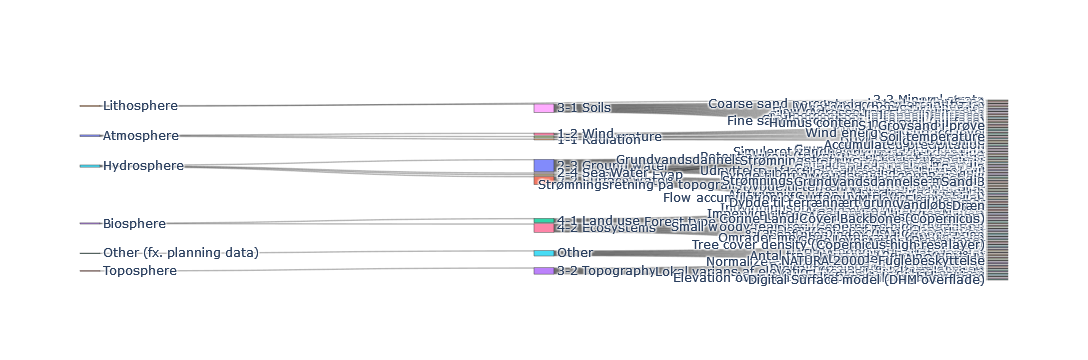

In [ ]:
fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": node_labels,

        'pad':10},  # 10 Pixels
    link = {
        "source": source_indices,
        "target": target_indices,
        "value": values}))

fig.show()

In [ ]:
target_indices

[14,
 16,
 7,
 13,
 15,
 12,
 6,
 8,
 17,
 9,
 11,
 10,
 18,
 126,
 58,
 36,
 113,
 20,
 39,
 122,
 120,
 124,
 40,
 95,
 24,
 129,
 82,
 37,
 22,
 52,
 42,
 96,
 70,
 41,
 108,
 81,
 111,
 59,
 56,
 78,
 87,
 84,
 46,
 91,
 85,
 63,
 97,
 71,
 66,
 72,
 127,
 48,
 100,
 62,
 49,
 112,
 110,
 47,
 69,
 130,
 77,
 68,
 23,
 103,
 83,
 98,
 131,
 28,
 89,
 38,
 101,
 75,
 51,
 123,
 116,
 54,
 65,
 125,
 34,
 57,
 109,
 115,
 44,
 121,
 99,
 64,
 73,
 27,
 45,
 88,
 26,
 31,
 118,
 86,
 50,
 21,
 60,
 93,
 102,
 61,
 119,
 53,
 128,
 132,
 80,
 105,
 92,
 33,
 55,
 74,
 107,
 25,
 79,
 43,
 106,
 30,
 104,
 94,
 117,
 90,
 35,
 76,
 32,
 19,
 29]

In [ ]:
node_labels

['Atmosphere',
 'Toposphere',
 'Other (fx. planning data)',
 'Biosphere',
 'Lithosphere',
 'Hydrosphere',
 '4-2 Ecosystems',
 '1-3 Temperature',
 '3-1 Soils',
 '2-1 Precip and Evap',
 '2-3 Ground water',
 '2-2 Surface water',
 '4-1 Land use',
 '3-2 Topography',
 '1-1 Radiation',
 'Other',
 '1-2 Wind',
 '3-3 Mineral strata',
 '2-4 Sea Water',
 'Prevailing wind direction',
 'DNI',
 'Indvindingsoplande i det primært magasin',
 'Forest type (MMU 0,5 ha.) (Copernicus high res. layer)',
 'Horisontalt flow',
 'NDVI (Copernicus)',
 'bredde på BNBO område',
 'Afgrødeforløb 2016-2023',
 'Redoxforhold dybde',
 'Grundvandsdannelse - Sand 4',
 'DHYM Havvand på land',
 'Beskyttet vandløb (NBL §3)',
 'Arealdække (worldcover sat)',
 'Wind energy at 100 m.',
 'Normalized DHM (height of surface features)',
 'Strømningsretning på topografisk overflade (topografisk flow direction)',
 'Wind exposure (index)',
 'Artsscore',
 'Small woody features (Copernicus high res. layer)',
 'Grundvandsdannelse - Sand 6'

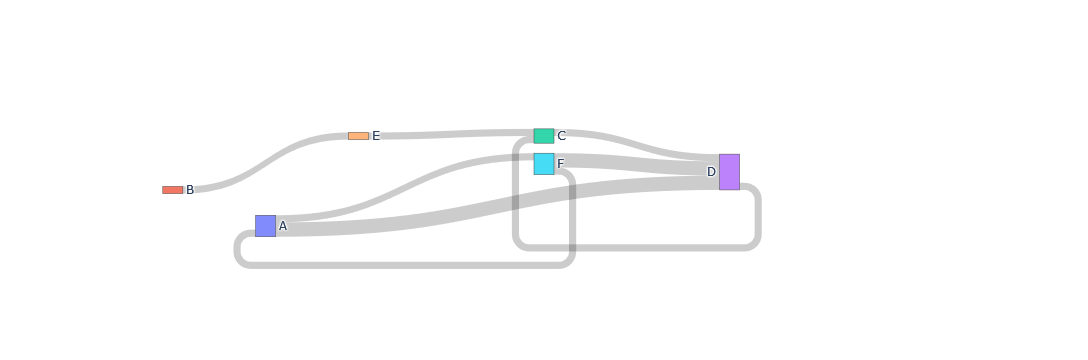

In [ ]:
fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": ["A", "B", "C", "D", "E", "F"],
        "x": [0.2, 0.1, 0.5, 0.7, 0.3, 0.5],
        "y": [0.7, 0.5, 0.2, 0.4, 0.2, 0.3],
        'pad':10},  # 10 Pixels
    link = {
        "source": [0, 0, 1, 2, 5, 4, 3, 5],
        "target": [5, 3, 4, 3, 0, 2, 2, 3],
        "value": [1, 2, 1, 1, 1, 1, 1, 2]}))

fig.show()